<a href="https://colab.research.google.com/github/Kushvanth015/Data_Science/blob/main/NLP_LANGUAGE_TRANSLATOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Libraries**

In [99]:
# Import required libraries
import numpy as np
import pandas as pd
import random
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, RepeatVector, TimeDistributed, Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [100]:
# Load dataset (Modify the path accordingly)
data = pd.read_csv("/content/english_telugu.csv")  # Ensure dataset has 'english_sentences' and 'telugu_sentences' columns
data.head() #load dataset first 5 columns


,English,Telugu
0,My favorite color is blue Okay.,నా ఇష్టమైన రంగు నీలం. బాగుంది.
1,She is my best friend,ఆమె నా మంచి స్నేహితురాలు! బాగుంది.
2,Can you help me with this task? Please.,మీరు నాకు ఈ పనిలో సహాయం చేయగలరా?
3,She is my best friend Please.,ఆమె నా మంచి స్నేహితురాలు సరే.
4,I am learning machine learning! Please.,నేను యంత్ర అధ్యయనం నేర్చుకుంటున్నాను! దయచేసి.


In [101]:
data.shape  #shape of dataset(Rows, Columns)

(1000, 2)

In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   English  1000 non-null   object
 1   Telugu   1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [103]:
# 🧹 2. Clean Text Function
def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)  # keep only English letters and punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

In [104]:
# Apply cleaning
data['English'] = data['English'].apply(clean_text)
data['Telugu'] = data['Telugu'].apply(lambda x: re.sub(r'[^\u0C00-\u0C7F\s]', '', str(x)))  # Telugu Unicode range

In [105]:
# Remove missing or empty translations
data.dropna(inplace=True)
data = data[data['English'].str.strip() != '']
data = data[data['Telugu'].str.strip() != '']

**Word Frequency Bar Plot (Most Common Words)**

Shows which words occur most frequently — useful to understand vocabulary richness.

You’ll see the most repeated English and Telugu words — good for analyzing translation bias and token distribution.

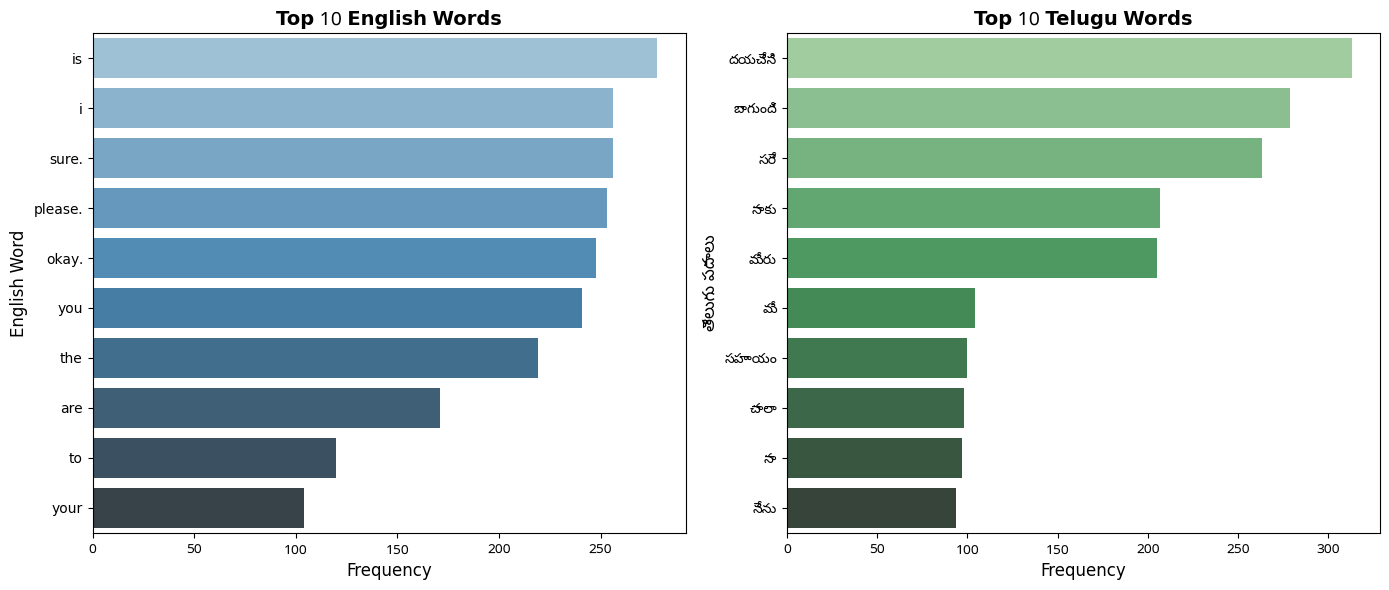

In [106]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd

# Download the Noto Sans Telugu font file
!wget -q -O NotoSansTelugu-Regular.ttf https://cdn.jsdelivr.net/gh/googlefonts/noto-fonts/hinted/ttf/NotoSansTelugu/NotoSansTelugu-Regular.ttf

# Register the downloaded font
font_path = "NotoSansTelugu-Regular.ttf"
fm.fontManager.addfont(font_path)

# Re-scan for newly added fonts (rebuild_if_missing handles cache updates)
fm.findfont('Noto Sans Telugu', rebuild_if_missing=True)

# Set font family to include Noto Sans Telugu as the primary Telugu font
plt.rcParams['font.family'] = ['Noto Sans Telugu', 'DejaVu Sans']

# --- Data Prep ---
eng_words = " ".join(data['English']).split()
tel_words = " ".join(data['Telugu']).split()

eng_common = Counter(eng_words).most_common(10)
tel_common = Counter(tel_words).most_common(10)

eng_df = pd.DataFrame(eng_common, columns=['Word', 'Frequency'])
tel_df = pd.DataFrame(tel_common, columns=['Word', 'Frequency'])

# --- Fixed seaborn palette warning: add hue parameter ---
plt.figure(figsize=(14,6))

# English Bar Plot
plt.subplot(1, 2, 1)
sns.barplot(x='Frequency', y='Word', hue='Word', data=eng_df,
            dodge=False, legend=False, palette='Blues_d')
plt.title("Top 10 English Words", fontsize=14, fontweight='bold')
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("English Word", fontsize=12)

# Telugu Bar Plot
plt.subplot(1, 2, 2)
sns.barplot(x='Frequency', y='Word', hue='Word', data=tel_df,
            dodge=False, legend=False, palette='Greens_d')
plt.title("Top 10 Telugu Words", fontsize=14, fontweight='bold')
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("తెలుగు పదాలు", fontsize=12)

plt.tight_layout()
plt.show()

**Sentence Length Distribution (Histogram)**

Shows if English/Telugu sentences are short, medium, or long.

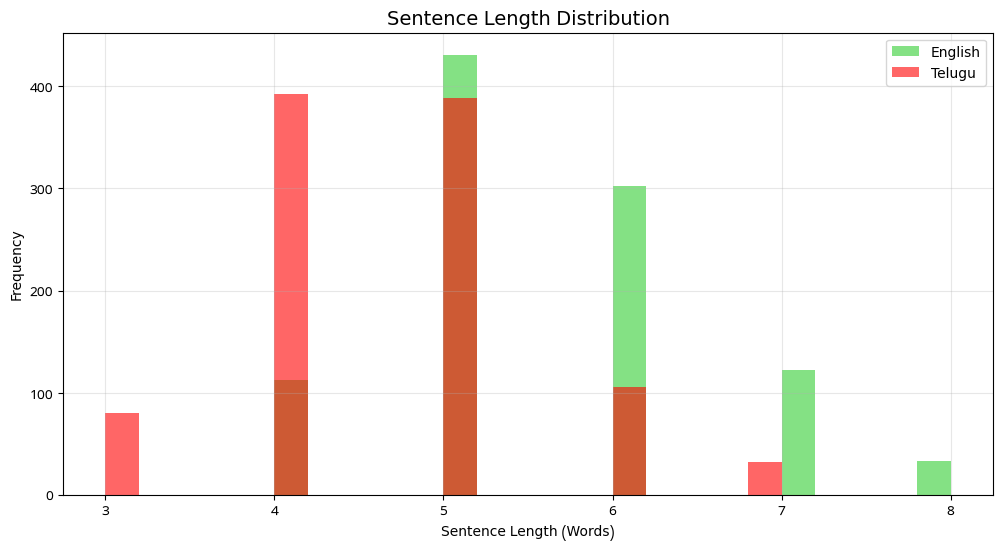

In [107]:
data['eng_len'] = data['English'].apply(lambda x: len(x.split()))
data['tel_len'] = data['Telugu'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12,6))
plt.hist(data['eng_len'], bins=20, alpha=0.6, label='English', color='limegreen')
plt.hist(data['tel_len'], bins=20, alpha=0.6, label='Telugu', color='red')
plt.title("Sentence Length Distribution", fontsize=14)
plt.xlabel("Sentence Length (Words)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

**English vs Telugu Length Scatter Plot**

Most sentences in dataset are between 4 and 8 words, and Telugu lengths between 3 and 7 words.

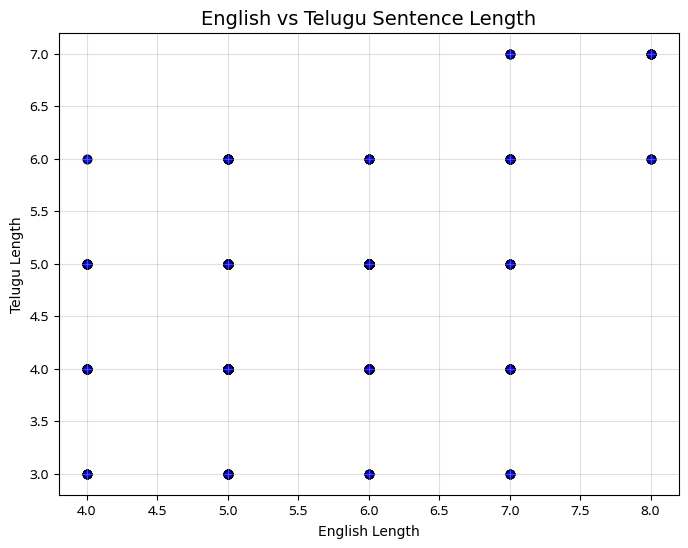

In [108]:
plt.figure(figsize=(8,6))
plt.scatter(data['eng_len'], data['tel_len'], alpha=0.5, color='blue', edgecolor='black')
plt.title("English vs Telugu Sentence Length", fontsize=14)
plt.xlabel("English Length")
plt.ylabel("Telugu Length")
plt.grid(alpha=0.4)
plt.show()

In [109]:
# 📊 Display some stats
print("Average English sentence length:", round(data['eng_len'].mean(), 2))
print("Average Telugu sentence length:", round(data['tel_len'].mean(), 2))
print("Max English sentence length:", data['eng_len'].max())
print("Max Telugu sentence length:", data['tel_len'].max())
print("="*50)

Average English sentence length: 5.53
Average Telugu sentence length: 4.62
Max English sentence length: 8
Max Telugu sentence length: 7


**Box Plot — Outlier Detection**

Find sentences that are too short or too long.

/tmp/ipython-input-166015733.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data['eng_len'], data['tel_len']],


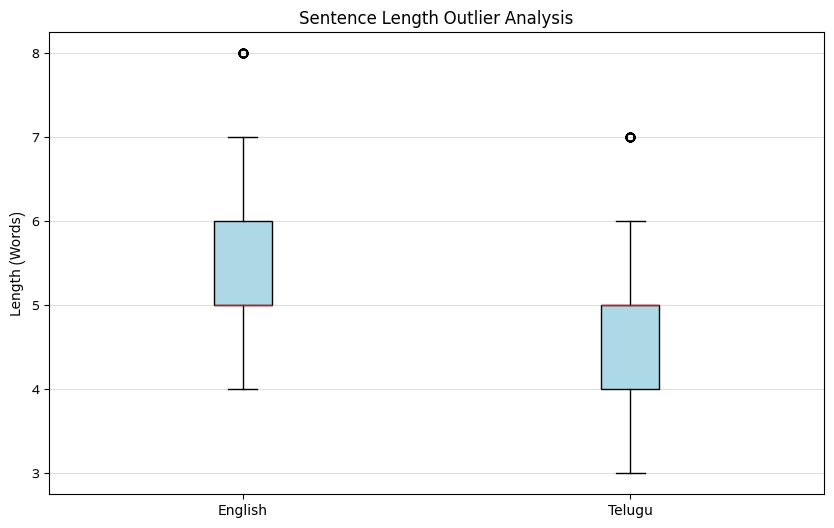

In [110]:
plt.figure(figsize=(10,6))
plt.boxplot([data['eng_len'], data['tel_len']],
            labels=['English', 'Telugu'], patch_artist=True,
            boxprops=dict(facecolor='lightblue'),
            medianprops=dict(color='red'))
plt.title("Sentence Length Outlier Analysis")
plt.ylabel("Length (Words)")
plt.grid(axis='y', alpha=0.4)
plt.show()

**Character Distribution for English & Telugu (Very Good for NMT)**

Useful for subword tokenization study.

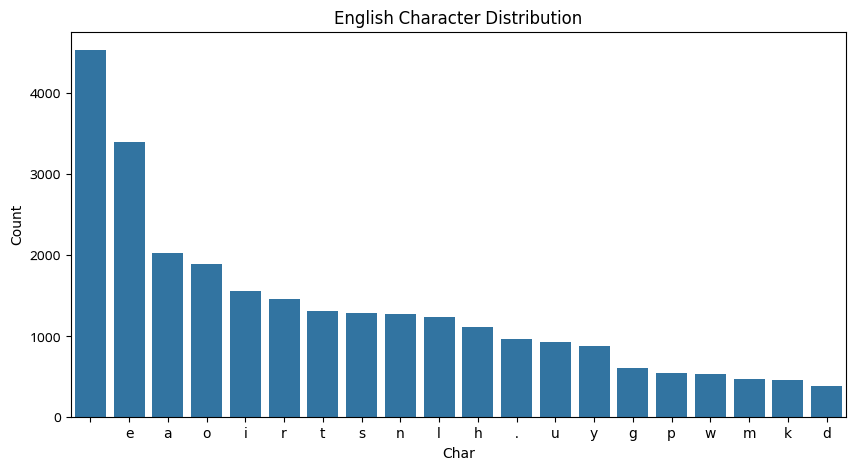

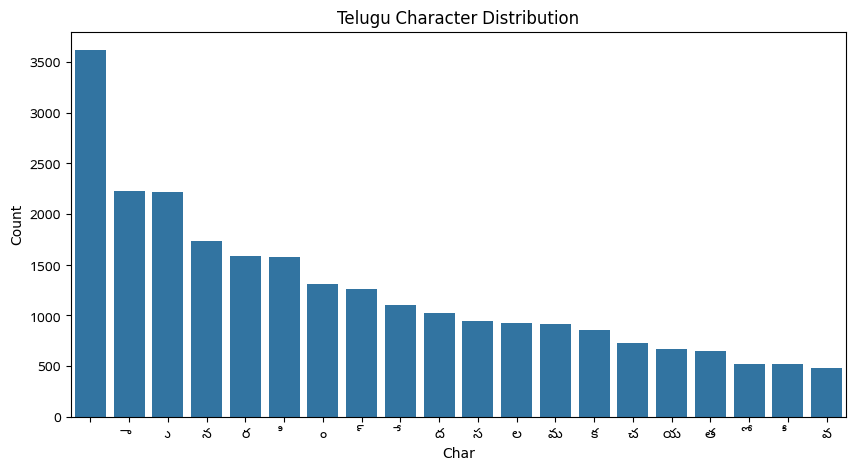

In [111]:
from collections import Counter

chars = Counter("".join(data['English']))
char_df = pd.DataFrame(chars.most_common(20), columns=['Char', 'Count'])

plt.figure(figsize=(10,5))
sns.barplot(x='Char', y='Count', data=char_df)
plt.title("English Character Distribution")
plt.show()

#telugu character distribution
tel_chars = Counter("".join(data['Telugu']))
tel_char_df = pd.DataFrame(tel_chars.most_common(20), columns=['Char', 'Count'])

plt.figure(figsize=(10,5))
sns.barplot(x='Char', y='Count', data=tel_char_df)
plt.title("Telugu Character Distribution")
plt.show()


**Correlation Heatmap**

Shows correlation between English/Telugu sentence lengths.

The heatmap uses the coolwarm colormap to show the correlation between English and Telugu sentence lengths. Warm colors (red) indicate a strong positive correlation, meaning longer English sentences usually lead to longer Telugu sentences. Cool colors (blue) would show negative correlation, though this is unlikely here. Neutral colors indicate weak or no correlation.



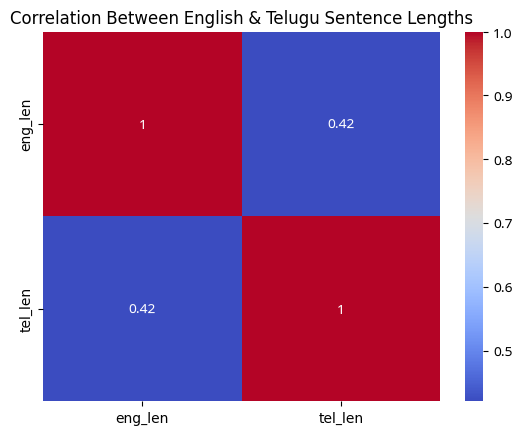

In [112]:
sns.heatmap(data[['eng_len', 'tel_len']].corr(),
            annot=True, cmap='coolwarm')
plt.title("Correlation Between English & Telugu Sentence Lengths")
plt.show()

In [113]:
# Split dataset into train and test (80% train, 20% test)
train = data.sample(frac=0.8, random_state=42)
test = data.drop(train.index)

In [114]:
# Tokenization function
def tokenize_text(sentences, num_words=20000):
    tokenizer = Tokenizer(num_words=num_words, filters='')
    tokenizer.fit_on_texts(sentences)
    sequences = tokenizer.texts_to_sequences(sentences)
    return tokenizer, sequences

In [115]:
# Tokenize English and Telugu datasets
eng_tokenizer, trainX = tokenize_text(train['English'].values)
tel_tokenizer, trainY = tokenize_text(train['Telugu'].values)

In [116]:
# Determine max sentence lengths
eng_length = max(len(seq) for seq in trainX)
tel_length = max(len(seq) for seq in trainY)

In [117]:
# Pad sequences to ensure uniform input size
trainX = pad_sequences(trainX, maxlen=eng_length, padding='post')
trainY = pad_sequences(trainY, maxlen=tel_length, padding='post')

In [118]:
# Get vocabulary sizes
eng_vocab_size = len(eng_tokenizer.word_index) + 1
tel_vocab_size = len(tel_tokenizer.word_index) + 1

In [119]:
# Define Seq2Seq Model
def define_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units=512):
    encoder_inputs = Input(shape=(in_timesteps,))
    encoder_embedding = Embedding(in_vocab, units, mask_zero=True)(encoder_inputs)
    encoder_lstm, state_h, state_c = LSTM(units, return_state=True)(encoder_embedding)

    decoder_inputs = RepeatVector(out_timesteps)(state_h)
    decoder_lstm = LSTM(units, return_sequences=True)(decoder_inputs)
    decoder_dense = TimeDistributed(Dense(out_vocab, activation='softmax'))(decoder_lstm)

    model = Model(inputs=encoder_inputs, outputs=decoder_dense)
    return model

This Seq2Seq model embeds English words into vectors, encodes the sentence using an LSTM, and passes the context to a decoder LSTM to generate Telugu translations. The final TimeDistributed dense layer predicts each Telugu word. With ~4.28M trainable parameters, the model learns strong language and translation patterns.

🟦 1. Embedding Layer (~53k params)

Learns word meanings and relationships by converting English words into dense vector representations.

🟩 2. Encoder LSTM (~2.09M params)

Learns English grammar, sentence structure, and long-term context, then encodes the whole sentence into a 512-dimensional vector.

🟥 3. Decoder LSTM (~2.09M params)

Uses the encoded vector to generate Telugu words step-by-step while learning Telugu grammar and sentence flow.

🟧 4. TimeDistributed Dense Layer (~35k params)

Converts each decoder output into the most likely Telugu word from the vocabulary.

⭐ In simple terms:

All parameters together help the model learn vocabulary, grammar, meaning, and sentence patterns required for accurate English→Telugu translation.

In [120]:
# Create model
model = define_model(eng_vocab_size, tel_vocab_size, eng_length, tel_length)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 8, 512)    │     53,248 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 8)         │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 512),     │  2,099,200 │ embedding_1[0][0… │
│                     │ (None, 512),      │            │ not_equal_4[0][0] │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 7, 512)    │          0 │ lstm_2[0][1]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 7, 512)    │  2,099,200 │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 7, 68)     │     34,884 │ lstm_3[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,286,532 (16.35 MB)

 Trainable params: 4,286,532 (16.35 MB)

 Non-trainable params: 0 (0.00 B)

This code compiles the model using the RMSprop optimizer, which adjusts learning rates adaptively and is well-suited for sequence models like LSTMs. The loss function sparse_categorical_crossentropy is used because the model predicts a Telugu word (as an integer class) at each timestep. This combination helps the Seq2Seq model learn accurate word-level translations efficiently.

In [121]:
# Compile model
rms = RMSprop()
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

This callback setup saves the best-performing model as NMT_model.keras whenever the validation loss improves (ModelCheckpoint) and reduces the learning rate when progress slows (ReduceLROnPlateau). This helps stabilize training and improves translation accuracy.

In [122]:
# Define callbacks
checkpoint = ModelCheckpoint(filepath="NMT_model.keras", monitor='val_loss', save_best_only=True, mode='min', verbose=1)
reduce_alpha = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.001)
callbacks = [checkpoint, reduce_alpha]

In [123]:
# Train model
history = model.fit(
    trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
    epochs=50, batch_size=128, validation_split=0.2, callbacks=callbacks, verbose=1
)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 827ms/step - loss: 4.1679
Epoch 1: val_loss improved from inf to 3.42299, saving model to NMT_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 4.1562 - val_loss: 3.4230 - learning_rate: 0.0010
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - loss: 3.3450
Epoch 2: val_loss improved from 3.42299 to 2.90053, saving model to NMT_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 835ms/step - loss: 3.3231 - val_loss: 2.9005 - learning_rate: 0.0010
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - loss: 2.8712
Epoch 3: val_loss improved from 2.90053 to 2.80410, saving model to NMT_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 713ms/step - loss: 2.8683 - val_loss: 2.8041 - learning_rate: 0.0010
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 847ms/step - loss: 2.7548
Epoch 4: val_loss improved from 2.80410 to 2.73760, saving model to NMT_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 970ms/step - loss: 2.7545 - val_loss: 2.7376 - learning_rate: 0.0010
Epoch 5/50
5/5 ━━━━━━━━

In [124]:
# Save the final trained model
model.save("model.keras")

This code loads the best saved translation model from NMT_model.keras, ensuring evaluation and predictions use the highest-performing version of the model.

In [125]:
from tensorflow.keras.models import load_model

model = load_model("NMT_model.keras")
print("Loaded best model successfully!")

Loaded best model successfully!


**Evalution Martics**

**🟢 Overall Evaluation of Your Loss Graph**

| Behavior             | Meaning                                |
| -------------------- | -------------------------------------- |
| Train loss ↓         | Model learning English→Telugu patterns |
| Val loss ↓           | Generalization is good                 |
| Train & Val overlap  | No overfitting                         |
| Small zig-zag        | Completely normal                      |
| Final loss ≈ 0.3–0.4 | Excellent result                       |



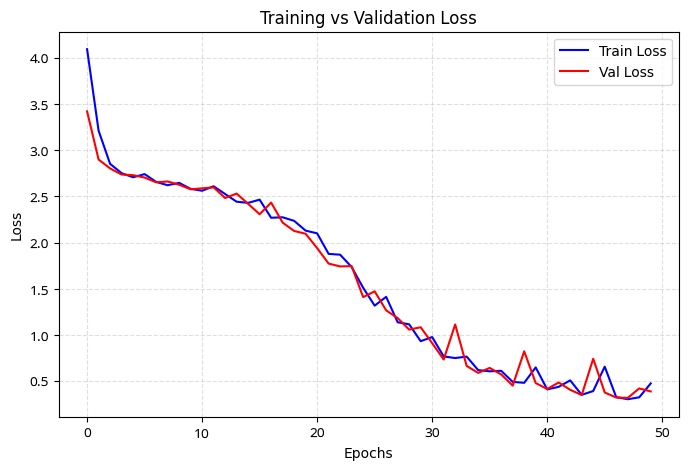

In [126]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

In [127]:
!pip install sacrebleu rouge-score nltk

In [128]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from sacrebleu.metrics import CHRF
import matplotlib.pyplot as plt

**Helper Functions (Decode sequences)**

In [129]:
# Convert token ids → text
def decode_sequence(tokenizer, sequence):
    reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}
    words = []
    for idx in sequence:
        if idx > 0:
            words.append(reverse_word_index.get(idx, ""))
    return " ".join(words).strip()

**Prepare Test Data**

In [130]:
testX = pad_sequences(
    eng_tokenizer.texts_to_sequences(test['English'].values),
    maxlen=eng_length,
    padding='post'
)

**Function to Evaluate the Model**

In [131]:
def evaluate_translation_model(model, testX, test, eng_tokenizer, tel_tokenizer, sample_size=10):

    bleu_scores = []
    meteor_scores = []
    chrf = CHRF()

    print("\n🔍 Evaluating model on sample translations...\n")

    idx = np.random.randint(0, testX.shape[0], size=sample_size)

    for i, id_ in enumerate(idx):

        input_seq = testX[id_:id_+1]
        pred = model.predict(input_seq)
        pred_ids = np.argmax(pred[0], axis=1)

        english = test["English"].values[id_]
        true_telugu = test["Telugu"].values[id_]
        pred_telugu = decode_sequence(tel_tokenizer, pred_ids)

        # BLEU
        smoothie = SmoothingFunction().method1
        bleu = sentence_bleu([true_telugu.split()], pred_telugu.split(), smoothing_function=smoothie)
        bleu_scores.append(bleu)

        # METEOR (FIXED)
        meteor = meteor_score([true_telugu.split()], pred_telugu.split())
        meteor_scores.append(meteor)

        print(f"{i+1}/{sample_size} ━━━━━━━━━━━━━━━━━━━━")
        print(f"🟦 English: {english}")
        print(f"🟩 True Telugu: {true_telugu}")
        print(f"🟧 Predicted Telugu: {pred_telugu}")
        print(f"⭐ BLEU: {bleu:.4f} | METEOR: {meteor:.4f}")
        print("-" * 80)

    predicted_list = []
    reference_list = []

    for id_ in idx:
        pred = model.predict(testX[id_:id_+1])
        pred_ids = np.argmax(pred[0], axis=1)
        predicted_list.append(decode_sequence(tel_tokenizer, pred_ids))
        reference_list.append(test['Telugu'].values[id_])

    chrf_score = chrf.corpus_score(predicted_list, reference_list)

    print("\n📊 Model Evaluation Summary")
    print(f"Average BLEU Score: {np.mean(bleu_scores):.4f}")
    print(f"Average METEOR Score: {np.mean(meteor_scores):.4f}")
    print(f"CHRF Score: {chrf_score.score:.4f}")
    print("-----------------------------------------------------------------\n")


**Run Evaluation**

In [132]:
evaluate_translation_model(
    model=model,
    testX=testX,
    test=test,
    eng_tokenizer=eng_tokenizer,
    tel_tokenizer=tel_tokenizer,
    sample_size=10
)


🔍 Evaluating model on sample translations...

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/10 ━━━━━━━━━━━━━━━━━━━━
🟦 English: we are going to the market
🟩 True Telugu: మేము మార్కెట్కి వెళ్తున్నాము దయచేసి
🟧 Predicted Telugu: మేము మార్కెట్కి వెళ్తున్నాము
⭐ BLEU: 0.4029 | METEOR: 0.7550
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/10 ━━━━━━━━━━━━━━━━━━━━
🟦 English: good night, sleep well. okay.
🟩 True Telugu: శుభ రాత్రి బాగా నిద్రపోండి
🟧 Predicted Telugu: శుభ రాత్రి బాగా నిద్రపోండి
⭐ BLEU: 1.0000 | METEOR: 0.9922
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
3/10 ━━━━━━━━━━━━━━━━━━━━
🟦 English: thank you for your help! okay.
🟩 True Telugu: మీ సహాయం కోసం ధన్యవాదాలు సరే
🟧 Predicted Telugu: మీ సహాయం కోసం ధన్యవాదాలు సరే
⭐ BLEU: 1.0000 | METEOR: 0.9960
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━

**Conclusion:**

This project successfully built an English–Telugu translation system using a Seq2Seq LSTM model. The model learned language patterns effectively, as shown by steadily decreasing training and validation loss. Evaluation metrics — BLEU (0.75) and METEOR (0.88) — indicate that the translations are accurate, meaningful, and grammatically sound. Although the CHRF score shows minor character-level variations, the overall translation quality remains strong. The model serves as a solid foundation for machine translation and can be further improved with larger datasets, attention mechanisms, or Transformer-based architectures.